In [1]:
# Perform an analysis using LDA as topic modelling algorithm and determine parameters via an optimization approach

In [2]:
import pickle
from gensim import matutils, models
import scipy.sparse
import pandas as pd
from gensim.models import CoherenceModel

In [3]:
# Set the class of tweets specifying the correct file
f_data = pd.read_csv('../data/negative_post_rebalancing.csv')
f_data.head(3)

,Datetime,Tweet Id,OriginalText,Username,Text_Cleaned,tokens,Text,Subjectivity,Polarity,NumberOfWords,MeanWordLength,P&SSentiment,SIA Positive Sentiment,SIA Neutral Sentiment,SIA Negative Sentiment
0,2021-10-27 23:39:35+00:00,1453506696094142469,@1goonrich Buy Dogus and make it 700k mc #NFTG...,aacryp,buy dogus and make it mc kishu hoge froge dog...,"['buy', 'dogus', 'make', 'kishu', 'hoge', 'fro...",buy dogus make kishu hoge froge doge dogus thi...,0.427273,-0.131818,29,5.69,Negative,0.000001,1.000001,0.000001
1,2021-10-27 23:32:41+00:00,1453504957991292933,💧 SupreSpace Metaverse 2nd Round Airdrop 💧\n\n...,AirdropStario,suprespace metaverse round airdrop task up to...,"['suprespace', 'round', 'airdrop', 'task', 'sa...",suprespace round airdrop task sapce referral s...,0.400000,-0.200000,10,6.60,Negative,0.000001,1.000001,0.000001
2,2021-10-27 23:31:03+00:00,1453504546345455619,@Elite_Portraits is now LIVE hand-crafting the...,DeployStarShip,is now live hand crafting the artwork for the ...,"['live', 'hand', 'crafting', 'artwork', 'plane...",live hand crafting artwork planet game claim p...,0.450000,-0.131818,14,5.93,Negative,0.198001,0.802001,0.000001


In [4]:
# Set the proper range of dates to analyze
f_data = f_data.loc[f_data['Datetime'] >= '2022-05-14']
f_data = f_data.loc[f_data['Datetime'] <= '2022-05-18']

In [5]:
# Create a document-term matrix using CountVectorizer, and exclude common English stop words
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(stop_words='english')
data_cv = cv.fit_transform(f_data.OriginalText)
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = f_data.index
tdm = data_dtm.transpose()

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [6]:
# Transofrm the term-document matrix into a new gensim format, df -> sparse matrix -> gensim corpus
sparse_counts = scipy.sparse.csr_matrix(data_dtm)
corpus = matutils.Sparse2Corpus(sparse_counts)

In [7]:
# Gensim  requires dictionary of the all terms and their respective location in the term-document matrix
cv = pickle.load(open("../data/cv_stop.pkl", "rb"))
id2word = dict((v, k) for k, v in cv.vocabulary_.items())

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.18.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [8]:
lsi = models.LsiModel(corpus, 3, id2word = id2word)
lsi.print_topics()

[(0,
  '0.156*"acknowledge" + 0.120*"airs" + 0.101*"april" + 0.096*"appreciate" + 0.094*"awards" + 0.088*"attacked" + 0.088*"arabs" + 0.087*"anyways" + 0.087*"advanced" + 0.087*"aside"'),
 (1,
  '0.284*"acknowledge" + -0.192*"automatic" + -0.158*"aaaaauuugghhhhhh" + 0.153*"arabs" + 0.153*"advanced" + -0.148*"baa" + 0.144*"aside" + -0.135*"aircrafts" + -0.124*"aaaaah" + -0.116*"assistant"'),
 (2,
  '-0.184*"added" + 0.177*"acknowledge" + -0.157*"aaaaah" + -0.148*"aaaahhhhh" + -0.145*"arguing" + -0.117*"amazed" + 0.117*"april" + -0.117*"audiences" + 0.116*"auditioning" + 0.113*"awards"')]

In [9]:
# Function to pull out nouns from a string of text
from nltk import word_tokenize, pos_tag

def nouns(text):
    '''Given a string of text, tokenize the text and pull out only the nouns.'''
    is_noun = lambda pos: pos[:2] == 'NN'
    tokenized = word_tokenize(text)
    all_nouns = [word for (word, pos) in pos_tag(tokenized) if is_noun(pos)]
    return ' '.join(all_nouns)

In [10]:
data_nouns = pd.DataFrame(f_data.Text.apply(nouns))

In [11]:
# Create a new document-term matrix using only nouns
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer

# Re-add the additional stop words
add_stop_words = ['like', 'im', 'know', 'just', 'dont', 'thats', 'right', 'people',
                  'youre', 'got', 'gonna', 'time', 'think', 'yeah', 'said']
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

# Recreate a document-term matrix with only nouns
cvn = CountVectorizer(stop_words=stop_words)
data_cvn = cvn.fit_transform(data_nouns.Text)
data_dtmn = pd.DataFrame(data_cvn.toarray(), columns=cvn.get_feature_names())
data_dtmn.index = data_nouns.index
data_dtmn

,abbath,ability,abode,abounds,access,account,accounts,act,activities,acts,...,zhuan,zi,zieneshisu,ziyade,znga,zombie,zoo,zuck,zuckerbergartnet,zuo
21418,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21419,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21420,0,0,0,0,0,0,0,0,0,0,...,3,1,0,0,0,0,0,0,0,1
21421,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21422,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21875,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21876,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21877,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21878,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
corpusn = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(data_dtmn.transpose()))
id2wordn = dict((v, k) for k, v in cvn.vocabulary_.items())

In [13]:
lsin = models.LsiModel(corpusn, 3, id2word = id2wordn)
lsin.print_topics()

[(0,
  '-0.429*"shi" + -0.419*"yi" + -0.229*"hua" + -0.226*"yu" + -0.206*"di" + -0.181*"yuan" + -0.181*"zhou" + -0.143*"xiang" + -0.140*"wei" + -0.138*"ge"'),
 (1,
  '0.276*"hua" + 0.257*"wei" + -0.252*"yu" + -0.202*"yuan" + -0.202*"zhou" + 0.194*"wen" + 0.193*"zhuan" + 0.193*"qian" + -0.158*"shi" + -0.149*"ge"'),
 (2,
  '-0.866*"game" + -0.213*"join" + -0.143*"play" + -0.129*"market" + -0.112*"nation" + -0.095*"players" + -0.087*"today" + -0.085*"sign" + -0.069*"discord" + -0.066*"gon"')]

In [14]:
# Function to pull out nouns from a string of text
def nouns_adj(text):
    is_noun_adj = lambda pos: pos[:2] == 'NN' or pos[:2] == 'JJ'
    tokenized = word_tokenize(text)
    nouns_adj = [word for (word, pos) in pos_tag(tokenized) if is_noun_adj(pos)]
    return ' '.join(nouns_adj)

In [15]:
data_nouns_adj = pd.DataFrame(f_data.Text.apply(nouns_adj))

In [16]:
# Create a new document-term matrix using only nouns and adjectives and remove common words with max_df
cvna = CountVectorizer(stop_words=stop_words, max_df=.8)
data_cvna = cvna.fit_transform(data_nouns_adj.Text)
data_dtmna = pd.DataFrame(data_cvna.toarray(), columns=cvna.get_feature_names())
data_dtmna.index = data_nouns_adj.index
data_dtmna

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,aaa,abbath,ability,abode,abounds,absolute,access,accessible,account,accounts,...,zhuan,zi,zieneshisu,ziyade,znga,zombie,zoo,zuck,zuckerbergartnet,zuo
21418,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21419,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21420,0,0,0,0,0,0,0,0,0,0,...,3,1,0,0,0,0,0,0,0,1
21421,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21422,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21875,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21876,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21877,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21878,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
corpusna = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(data_dtmna.transpose()))
id2wordna = dict((v, k) for k, v in cvna.vocabulary_.items())

In [21]:
lsina = models.LsiModel(corpus=corpusna, num_topics=3, id2word=id2wordna)
lsina.print_topics()

[(0,
  '0.429*"shi" + 0.419*"yi" + 0.229*"hua" + 0.226*"yu" + 0.206*"di" + 0.181*"zhou" + 0.181*"yuan" + 0.143*"xiang" + 0.141*"wei" + 0.138*"ge"'),
 (1,
  '-0.276*"hua" + -0.257*"wei" + 0.252*"yu" + 0.202*"yuan" + 0.202*"zhou" + -0.195*"wen" + -0.193*"qian" + -0.193*"zhuan" + 0.158*"shi" + 0.149*"ge"'),
 (2,
  '0.810*"game" + 0.199*"join" + 0.150*"market" + 0.135*"moon" + 0.131*"nation" + 0.127*"play" + 0.126*"new" + 0.091*"shill" + 0.088*"players" + 0.085*"sign"')]

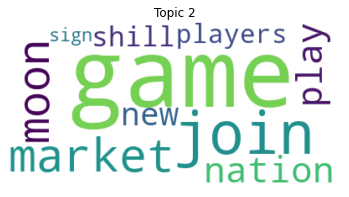

In [24]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt
def create_wordcloud(model, topic):
    text = {word: value for word, value in model.show_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title("Topic" + " "+ str(topic))
    plt.show()
create_wordcloud(lsina,2)

In [25]:
from gensim import corpora
word2id = dict((k, v) for k, v in cvna.vocabulary_.items())
d = corpora.Dictionary()
d.id2token = id2word
d.token2id = word2id

In [26]:
def compute_coherence_values(corpus, dictionary, k):
    lsi_model = models.LsiModel(corpus=corpus, num_topics=k, id2word=dictionary)
    coherence_model_lda = CoherenceModel(model=lsi_model, corpus=corpus,dictionary=dictionary, coherence='u_mass')
    return coherence_model_lda.get_coherence()

In [27]:
from gensim import models

# Topics range
min_topics = 2
max_topics = 10
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

model_results = {
                 'Topics': [],
                 'Coherence': []
                }

if 1 == 1:
    # iterate through number of topics
    for k in topics_range:
        # get the coherence score for the given parameters
        cv = compute_coherence_values(corpus=corpusna, dictionary=d,
                                                  k=k)
        # save the  results
        model_results['Topics'].append(k)
        model_results['Coherence'].append(cv)

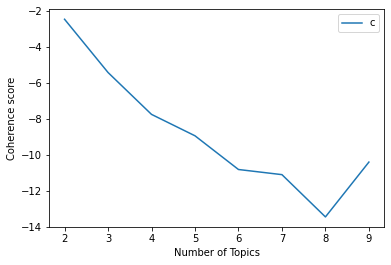

In [28]:
import matplotlib.pyplot as plt
plt.plot(model_results['Topics'], model_results['Coherence'])
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend("coherence_values", loc='best')
plt.show()

In [29]:
results = pd.DataFrame(model_results)

In [30]:
results.to_csv("../data/resultsLSI062022.csv",index=False)